# UAV Detection and Tracking

## Task 1A: Setup Dev Environment and Storing Videos Locally

### Youtube Downloader Class

In [ ]:
%pip install pytube
%pip install opencv-python
%pip install ultralytics

In [2]:
from pytube import YouTube
from typing import List
import os


class YouTubeDownloader:
  def __init__(self, download_path: str = "./downloads"):
    if not os.path.exists(download_path):
      os.makedirs(download_path)
    self.download_path: str = download_path

  def download_video(self, url: str):
    yt = YouTube(url)
    video = (
      yt.streams.filter(progressive=True, file_extension="mp4")
      .order_by("resolution")
      .desc()
      .first()
    )

    video_filename = f"{yt.title}.mp4"
    if os.path.exists(os.path.join(self.download_path, video_filename)):
      return

    video.download(self.download_path)
    print(f"Downloaded {video_filename}")

  def download_videos(self, video_urls: List[str]):
    for url in video_urls:
      try:
        self.download_video(url)
      except Exception as e:
        print(f"Error downloading video: {url}. Reason: {e}")

### Download them Locally

In [2]:
downloader = YouTubeDownloader()
video_urls = [
    "https://www.youtube.com/watch?v=DhmZ6W1UAv4",
    "https://www.youtube.com/watch?v=YrydHPwRelI"
]
downloader.download_videos(video_urls)

Downloaded Drone Tracking 1.mp4
Downloaded Drone tracking 2.mp4


## Task 1B: Drone Object Detection

### Dataset Images and their Bounding Boxes

In [3]:
import cv2
# Function to draw bounding boxes on the image
def draw_boxes(image, boxes):
    for box in boxes:
        x, y, w, h = box.astype(int)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return image

In [ ]:
import scipy.io
import matplotlib.pyplot as plt

base_dir = 'data/image_label/'

# Iterate over each subdirectory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    
    # Check if it's indeed a directory
    if os.path.isdir(subdir_path):
        # There should be one .mat file per subdirectory
        mat_file_path = os.path.join(subdir_path, 'anotation.mat')
        mat_data = scipy.io.loadmat(mat_file_path)
        boxes = mat_data['box'] 

        # List all image files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path) if f.endswith(('.jpg', '.png'))]
        # Sort the image files by increasing index to match the bounding boxes
        image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))

        if len(boxes) != len(image_files):
            print(f"Warning: The number of bounding boxes does not match the number of images in {subdir_path}")
            continue

        # Iterate over each image and the corresponding bounding box
        for img_file, box in zip(image_files[:2], boxes[:2]):
            image_path = os.path.join(subdir_path, img_file)
            image = cv2.imread(image_path)

            # Draw the bounding box
            image_with_boxes = draw_boxes(image, [box])

            # Save or display the image
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.show()


### Prepare the Dataset

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Define the directories where the training and validation images will be saved
train_dir = 'data/train/'
val_dir = 'data/val/'

# Make sure the directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Lists to hold all train and val image paths
train_image_paths = []
val_image_paths = []

# Iterate over each subdirectory in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    
    if os.path.isdir(subdir_path):
        mat_file_path = os.path.join(subdir_path, 'anotation.mat')
        mat_data = scipy.io.loadmat(mat_file_path)
        boxes = mat_data['box']

        image_files = [f for f in os.listdir(subdir_path) if f.endswith(('.jpg', '.png'))]
        image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))

        if len(boxes) != len(image_files):
            print(f"Warning: The number of bounding boxes does not match the number of images in {subdir_path}")
            continue

        # Split the images into train and val sets
        train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

        # Function to process and move files
        def process_files(files, destination, image_paths, subdir_name):
            for img_file in files:
                # Create a unique filename by prefixing it with the subdir name
                unique_filename = f"{subdir_name}_{img_file}"
                unique_txt_filename = unique_filename.replace('.jpg', '.txt').replace('.png', '.txt')
                image_path = os.path.join(subdir_path, img_file)
                image = cv2.imread(image_path)
                h, w = image.shape[:2]
                box_index = image_files.index(img_file)
                box = boxes[box_index]

                # Construct the full path for the new destination
                dest_image_path = os.path.join(destination, unique_filename)
                dest_txt_path = dest_image_path.replace('.jpg', '.txt').replace('.png', '.txt')

                with open(dest_txt_path, 'w') as f:
                    x_center = (box[0] + box[2] / 2) / w
                    y_center = (box[1] + box[3] / 2) / h
                    width = box[2] / w
                    height = box[3] / h
                    f.write(f"0 {x_center} {y_center} {width} {height}\n")

                # Move the image to the destination directory
                shutil.move(image_path, dest_image_path)

                # Add the image path to the list
                image_paths.append(dest_image_path)

        # Process and move train and val files
        process_files(train_images, train_dir, train_image_paths, subdir)
        process_files(val_images, val_dir, val_image_paths, subdir)

# Write the image paths to the master train and val list files
with open(os.path.join(train_dir, 'train.txt'), 'w') as f:
    f.write('\n'.join(train_image_paths))

with open(os.path.join(val_dir, 'val.txt'), 'w') as f:
    f.write('\n'.join(val_image_paths))

### Check the Image and its Bounding Boxes

#### Function to Draw Box from YOLO format

In [3]:
def draw_boxes(image, boxes):
    h, w = image.shape[:2]  # get the height and width of the image
    for box in boxes:
        # Convert YOLO format to (x1, y1, x2, y2)
        x_center, y_center, width, height = box
        x_center, y_center, width, height = float(x_center), float(y_center), float(width), float(height)

        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return image

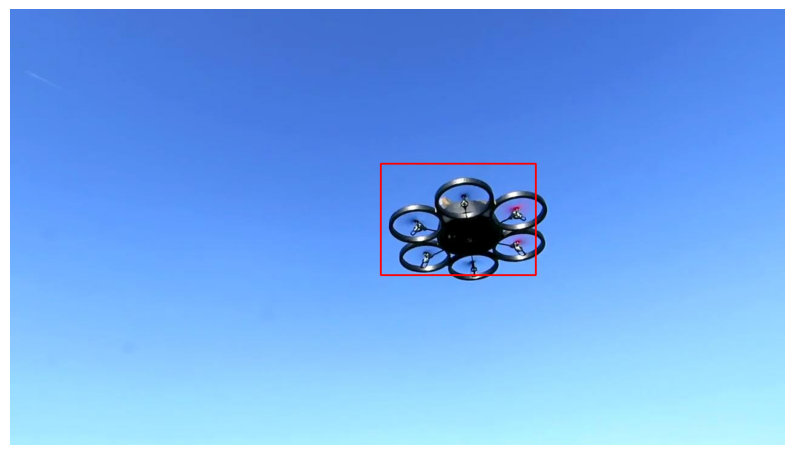

In [6]:
# Define the directory where the training images and box text files are located
train_dir = 'data/train/'

# Select a random image file from the training directory
image_files = [f for f in os.listdir(train_dir) if f.endswith(('.jpg', '.png'))]
image_file = image_files[0]  # Replace with a specific file if you want to check a particular image

# Define the corresponding .txt file for the bounding box
txt_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
txt_path = os.path.join(train_dir, txt_file)

# Read the bounding box data from the .txt file
boxes = []
with open(txt_path, 'r') as f:
    for line in f.readlines():
        _, x_center, y_center, width, height = line.strip().split()
        boxes.append((x_center, y_center, width, height))

# Read the image
image_path = os.path.join(train_dir, image_file)
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print(f"Could not read the image {image_file}")
else:
    
    image_with_boxes = draw_boxes(image, boxes)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

### Load the YOLOv8 Model

In [7]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.208 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
Setup complete ✅ (20 CPUs, 15.5 GB RAM, 216.1/250.9 GB disk)


### Create Config File

In [8]:
CONFIG = """
# train and val datasets
train: train/
val: val/

# number of classes
nc: 1

# class names
names: ['drone']
"""

with open("data/data.yaml", "w") as f:
    f.write(CONFIG)

### Train the Model

In [85]:
from ultralytics import YOLO 

# Define the path to the dataset and YAML file
data_yaml = 'data/data.yaml' 

# Initialize the model
model = YOLO('yolov8s.pt')

# Train the model
model.train(data=data_yaml, epochs=50, batch=20, workers=8, project='drone_detection', device='0')

Ultralytics YOLOv8.0.208 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data/data.yaml, epochs=50, patience=50, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=drone_detection, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f89c6480790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [2]:
from ultralytics import YOLO 

data_yaml = 'data/data.yaml' 

model = YOLO('drone_detection/train3/weights/best.pt')

# Train the model
model.train(data=data_yaml, epochs=10, batch=20, workers=8, project='drone_detection', device='0')

Ultralytics YOLOv8.0.208 🚀 Python-3.8.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
engine/trainer: task=detect, mode=train, model=drone_detection/train3/weights/best.pt, data=data/data.yaml, epochs=10, patience=50, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=drone_detection, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f5f99122fd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Load the Trained Model

In [1]:
from ultralytics import YOLO 

model = YOLO('drone_detection/train4/weights/best.pt')

### Detect Drone in the Images and Draw Bounding Boxes


0: 384x640 1 drone, 15.7ms
Speed: 1.8ms preprocess, 15.7ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


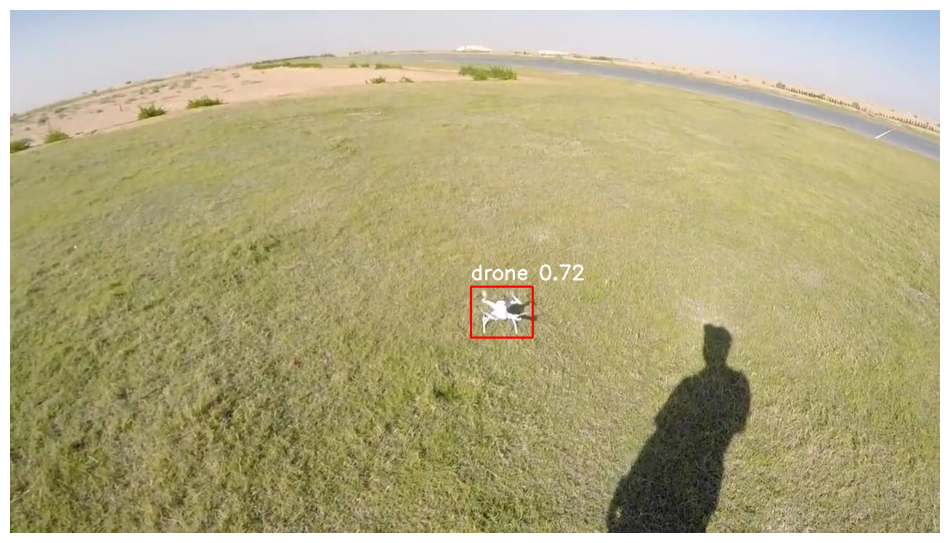


0: 384x640 1 drone, 32.6ms
Speed: 2.4ms preprocess, 32.6ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


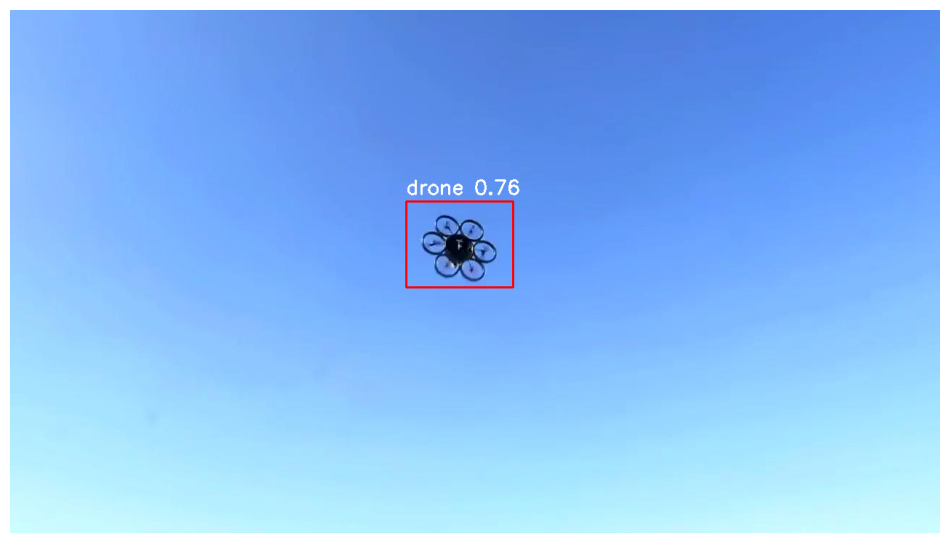


0: 384x640 1 drone, 23.9ms
Speed: 1.6ms preprocess, 23.9ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


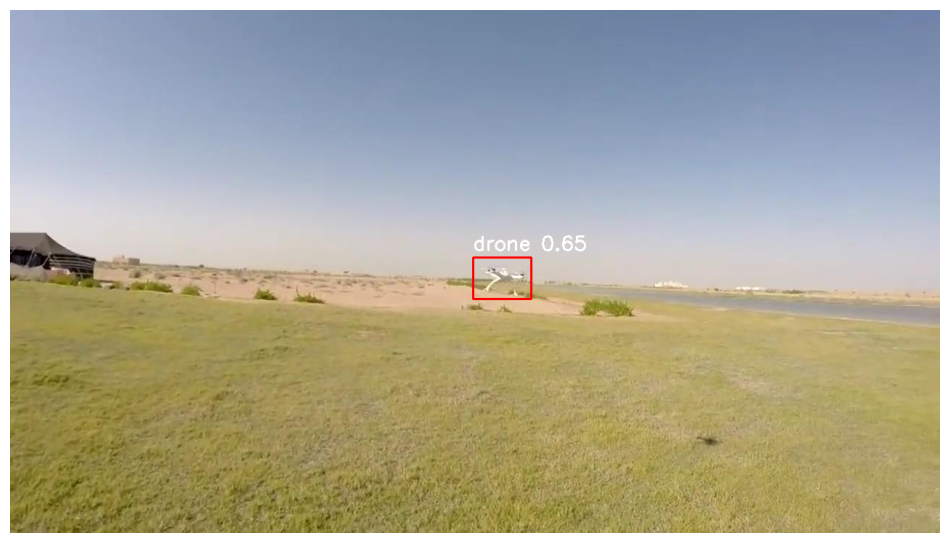


0: 384x640 1 drone, 22.8ms
Speed: 1.9ms preprocess, 22.8ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


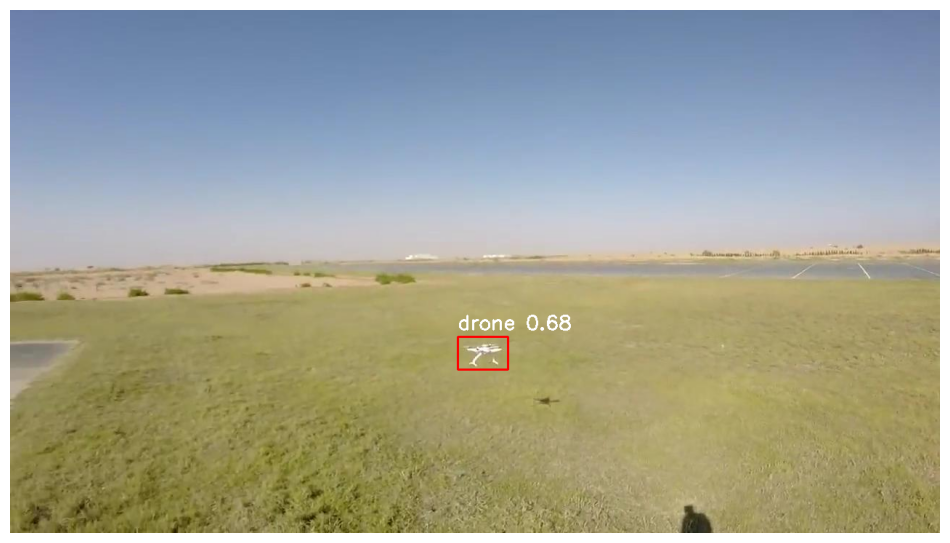


0: 384x640 1 drone, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


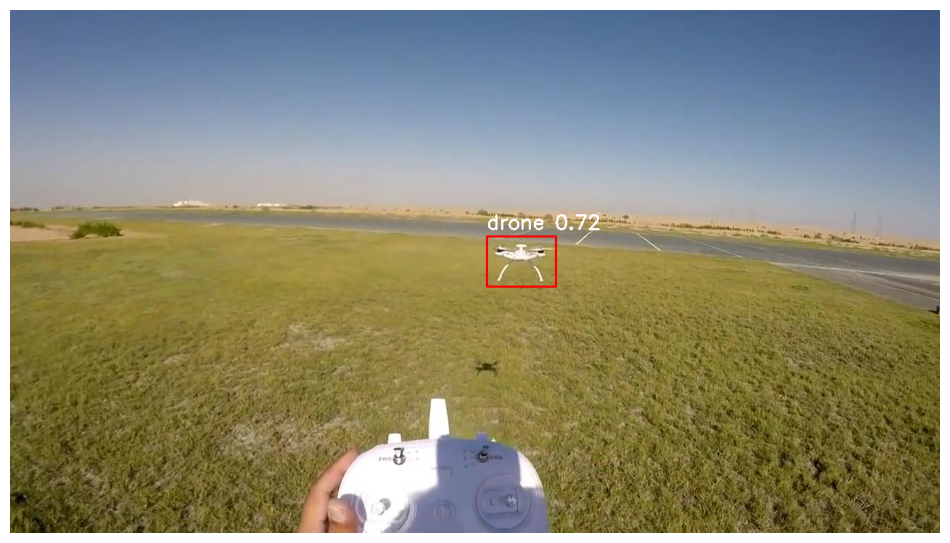

In [10]:
import random
import numpy as np

val_dir = 'data/val/'

# Get a list of all image files in the validation directory
image_files = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.endswith(('.jpg', '.png'))]

# Randomly select a few images
selected_images = random.sample(image_files, 5)

for image_path in selected_images:
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image {image_path}")
        continue
    
    img = np.asarray(img)

    results = model.predict(img)

    # Extract boxes from results
    for result in results:
        if hasattr(result, 'boxes') and hasattr(result.boxes, 'xyxy') and result.boxes.xyxy.numel() > 0:
            box = result.boxes.xyxy[0].cpu().numpy()  # Extract bounding box coordinates
            names = result.names
            orig_img = result.orig_img
        
            x1, y1, x2, y2 = box[:4].astype(int)
            conf = result.boxes.conf[0] # Confidence of the prediction
            label = f"{result.names[0]} {conf:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        
        
            orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
            # Display the image
            plt.figure(figsize=(12, 8))
            plt.imshow(orig_img_rgb)
            plt.axis('off')
            plt.show()

### Running the Model on Video

In [5]:
# Directories
video_dir = 'downloads/'
detections_dir = 'detections/'
os.makedirs(detections_dir, exist_ok=True)

# Process videos
for video_name in os.listdir(video_dir):
    video_path = os.path.join(video_dir, video_name)
    if not video_name.endswith(('.mp4')):
        continue  # Skip non-video files

    # Open the video
    cap = cv2.VideoCapture(video_path)
    print(f"Processing video: {video_name}")
    if not cap.isOpened():
        print(f"Error opening video file {video_name}")
        continue

    frame_count = 0
    while True:
        # Read a frame
        ret, frame = cap.read()
        if not ret:
            break  # Break if there are no frames left

        # Run inference on the frame
        results = model.predict(frame)

        # Check for any detections with a high confidence
        for result in results:
            if hasattr(result, 'boxes') and hasattr(result.boxes, 'xyxy') and result.boxes.xyxy.numel() > 0:
                box = result.boxes.xyxy[0].cpu().numpy()
                x1, y1, x2, y2 = box[:4].astype(int)
                conf = result.boxes.conf[0] # Confidence of the prediction
                label = f"{result.names[0]} {conf:.2f}"

                if conf > 0.45: # Only save detections with confidence greater than 0.45 
                    # Draw bounding box and label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
                    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                    # Save frame if a detection is found
                    detection_frame_path = os.path.join(detections_dir, f"{video_name}_frame_{frame_count}.jpg")
                    cv2.imwrite(detection_frame_path, frame)
                    break  # Break if we've already found a detection in this frame

        frame_count += 1

    # Release the video capture object
    cap.release()

0: 384x640 (no detections), 25.7ms
Speed: 1.8ms preprocess, 25.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.9ms
Speed: 1.7ms preprocess, 12.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 26.4ms
Speed: 1.8ms preprocess, 26.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 20.9ms
Speed: 1.5ms preprocess, 20.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)



Processing video: Drone tracking 2.mp4


0: 384x640 (no detections), 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.8ms
Speed: 1.5ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.1ms
Speed: 1.1ms preprocess, 10.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.6ms
Speed: 1.2ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.0ms
Speed: 1.1ms preprocess, 10.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.5ms
Speed: 1.1ms preprocess, 13.5ms in

Processing video: Drone Tracking 1.mp4



0: 384x640 1 drone, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 6.8ms
Speed: 1.1ms preprocess, 6.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 drone, 6.5ms
Speed: 1.1ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 

### Detections on Videos

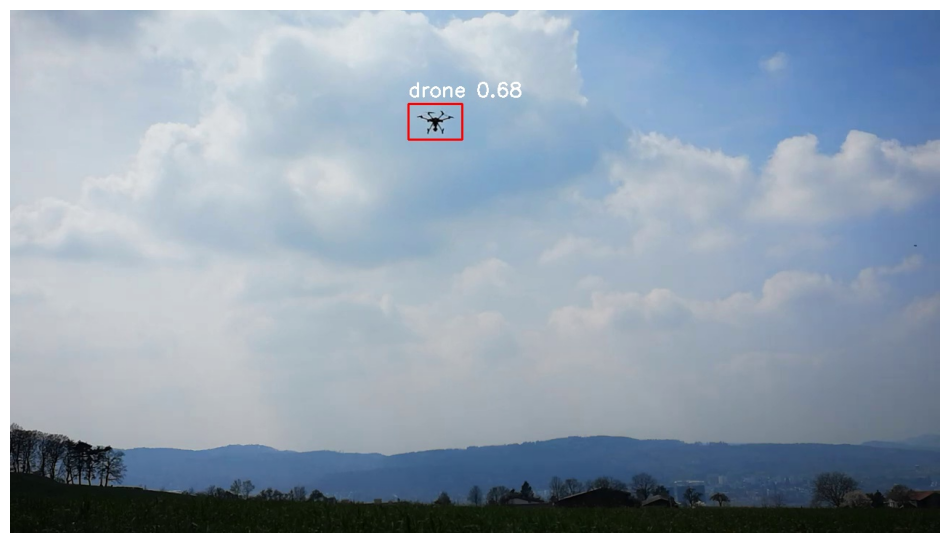

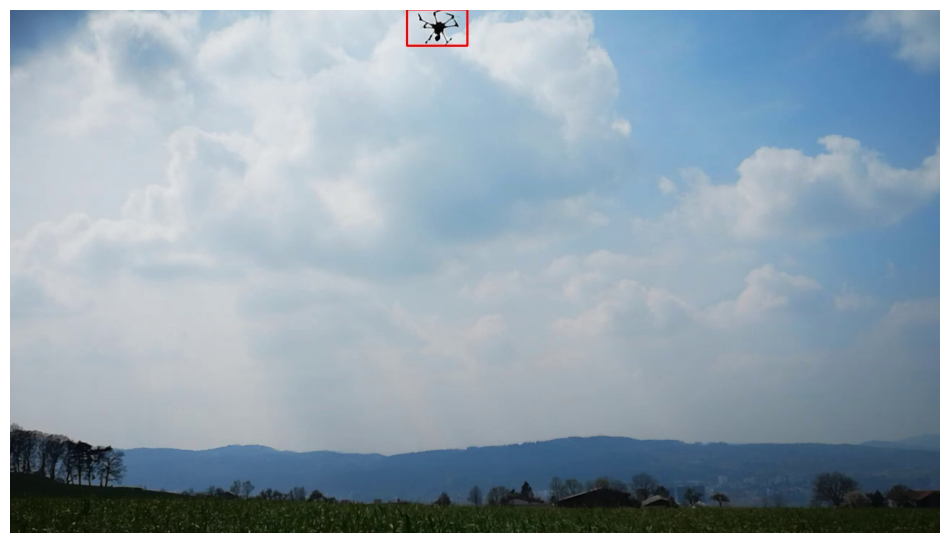

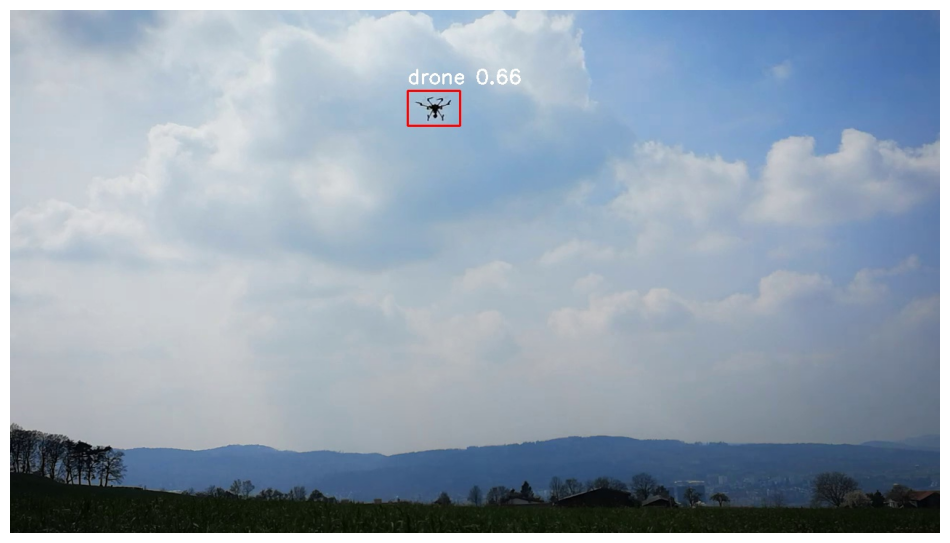

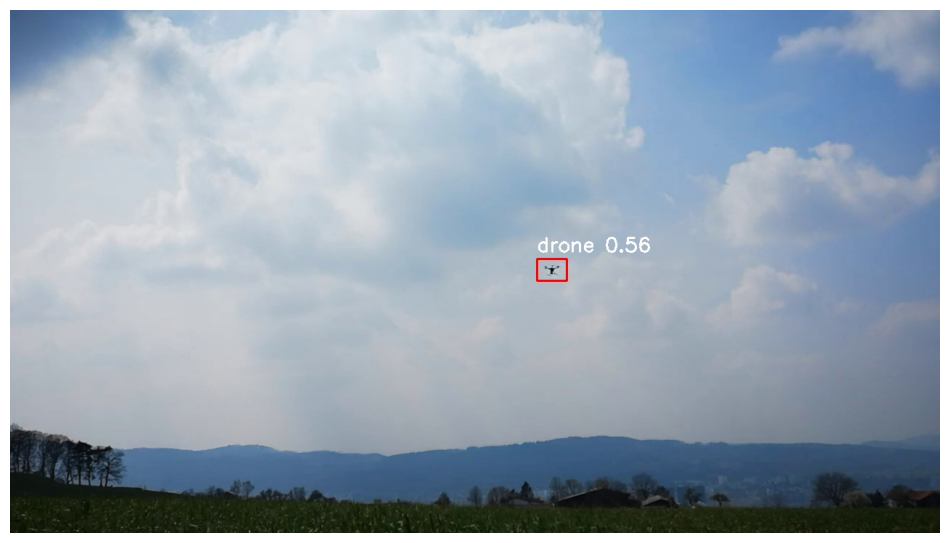

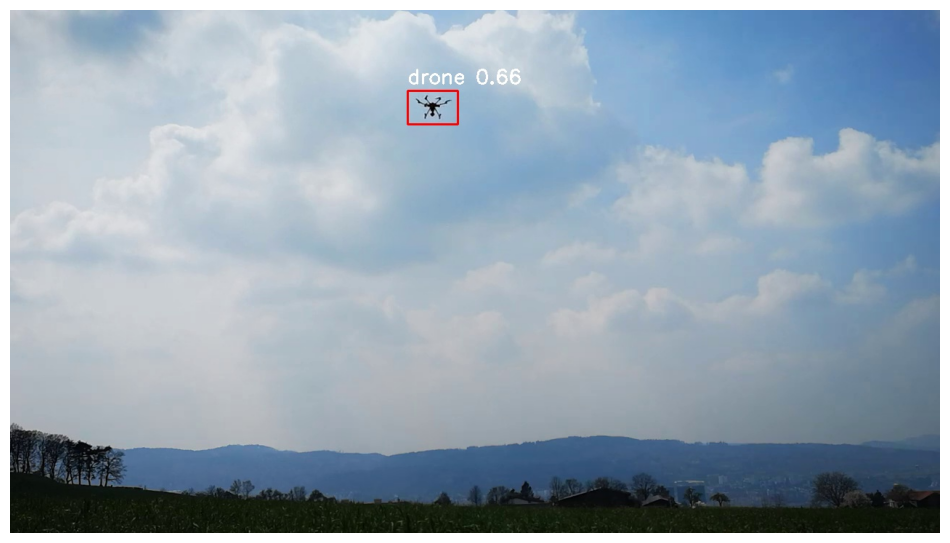

In [6]:
import cv2
from matplotlib import pyplot as plt
import random

# Directory where detections are stored
detections_dir = 'detections/'

# Get all saved detection images
detection_images = [os.path.join(detections_dir, f) for f in os.listdir(detections_dir) if f.endswith('.jpg')]

# Randomly select 5 detection images
selected_images = random.sample(detection_images, 5) if len(detection_images) >= 5 else detection_images

# Display the selected images
for image_path in selected_images:
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image {image_path}")
        continue
    
    # Convert color from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(image_path)
    plt.axis('off')  # Hide the axis
    plt.show()